# **SMS Spam Classification Model using Naive Bayes**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/DSS/SMSSpamCollection.txt'
df = pd.read_csv(file_path, delimiter='\t', header=None, skipinitialspace=True, names=['label','message'])
print(df)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


## Đánh giá bộ dữ liệu

Thống kê dữ liệu

In [4]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

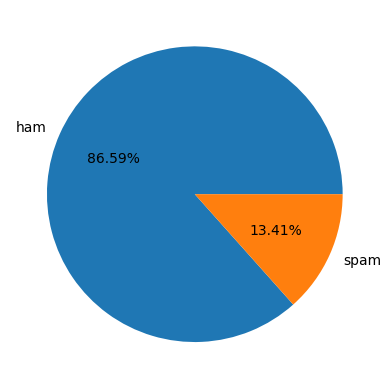

In [5]:
plt.pie(df['label'].value_counts(),labels=['ham','spam'],autopct='%0.2f%%')
plt.show()

Tính tổng số ký tự

In [6]:
#Tổng số ký tự
df['num_char']=df['message'].apply(len)
#Tổng số từ
df['num_words']=df['message'].apply(lambda x: len(str(x).split()))
#Tổng số câu
df['num_sen']=df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df

,label,message,num_char,num_words,num_sen
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,2
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2
3,ham,U dun say so early hor... U c already then say...,49,11,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,1
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,30,4
5568,ham,Will ü b going to esplanade fr home?,36,8,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,10,2
5570,ham,The guy did some bitching but I acted like i'd...,125,26,1


Trực quan dữ liệu theo số ký tự, số từ, số câu

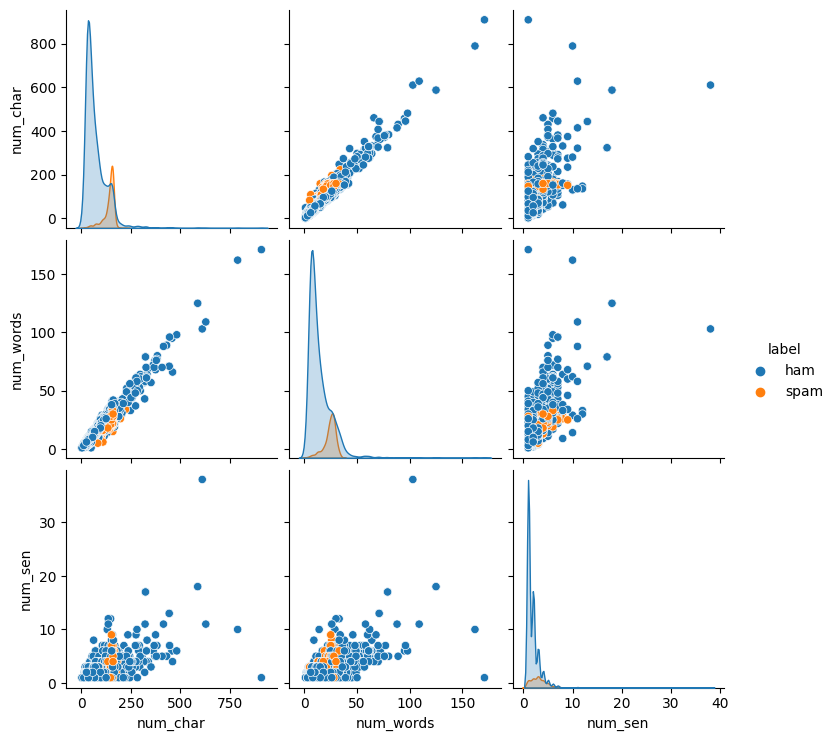

In [7]:
sns.pairplot(df,hue='label')
plt.show()

# Tiền xử lý dữ liệu

In [8]:
#Import lib required for text processing
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import string,time
string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Xóa link, email, số

In [9]:
def remove_website_links(text):
    no_website_links = text.replace(r"http\S+", "")
    return no_website_links

def remove_numbers(text):
    removed_numbers = text.replace(r'\d+','')
    return removed_numbers

def remove_emails(text):
    no_emails = text.replace(r"\S*@\S*\s?",'')
    return no_emails

In [10]:
df['message'] = df['message'].apply(remove_website_links)
df['message'] = df['message'].apply(remove_numbers)
df['message'] = df['message'].apply(remove_emails)

In [11]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Hàm xử lý dữ liệu


In [12]:
def transform_text(text):
    #1.lower casing
    text=text.lower()

    #2.tokenization
    lst=nltk.word_tokenize(text)

    #3.remove spcl characters stopwords and punctuation
    l1=[]
    useless_words=stopwords.words('english')+list(string.punctuation)
    for word in lst:
        if word.isalnum()==True and word not in useless_words:
            l1.append(word)

    #4.stemming
    l2=[]
    for word in l1:
        ps=PorterStemmer()
        l2.append(ps.stem(word))

    return " ".join(l2).strip()
    l1.clear()
    l2.clear()


In [13]:
df['transformed_text'] = df['message'].apply(transform_text)

In [14]:
df.head()

,label,message,num_char,num_words,num_sen,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,6,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,11,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,1,nah think goe usf live around though


Đổi label sang nhị phân 0,1

In [15]:
df['label']=df['label'].replace({'spam':0,'ham':1})
df

,label,message,num_char,num_words,num_sen,transformed_text
0,1,"Go until jurong point, crazy.. Available only ...",111,20,2,go jurong point crazi avail bugi n great world...
1,1,Ok lar... Joking wif u oni...,29,6,2,ok lar joke wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2,free entri 2 wkli comp win fa cup final tkt 21...
3,1,U dun say so early hor... U c already then say...,49,11,1,u dun say earli hor u c alreadi say
4,1,"Nah I don't think he goes to usf, he lives aro...",61,13,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,160,30,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,1,Will ü b going to esplanade fr home?,36,8,1,ü b go esplanad fr home
5569,1,"Pity, * was in mood for that. So...any other s...",57,10,2,piti mood suggest
5570,1,The guy did some bitching but I acted like i'd...,125,26,1,guy bitch act like interest buy someth els nex...


Bộ dữ liệu sau khi xử lý

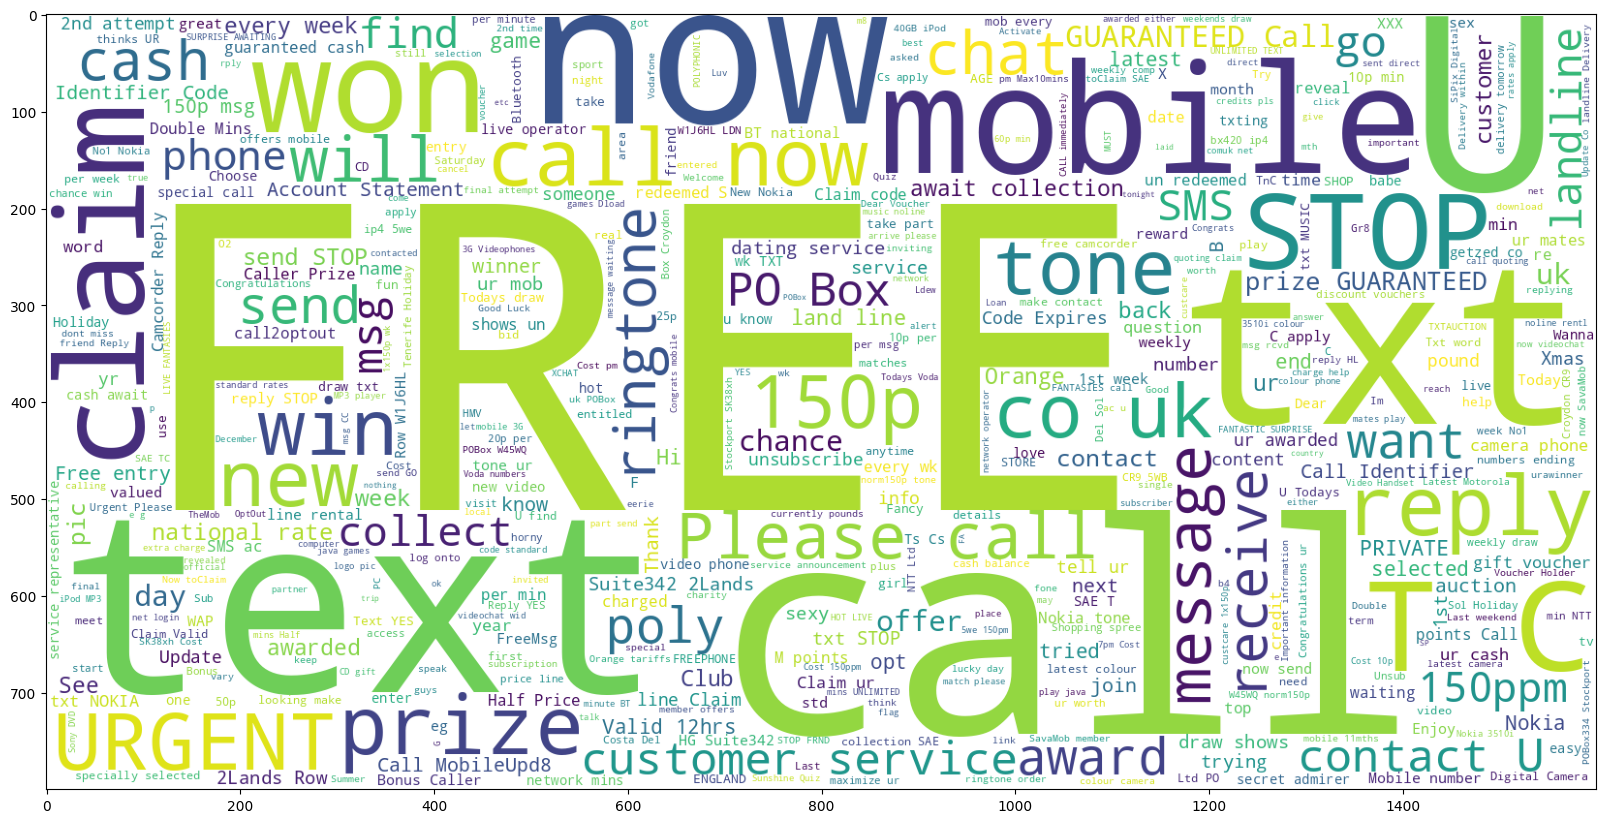

In [16]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 500,background_color='white').generate(" ".join(df[df.label == 0].message))
plt.imshow(wc)

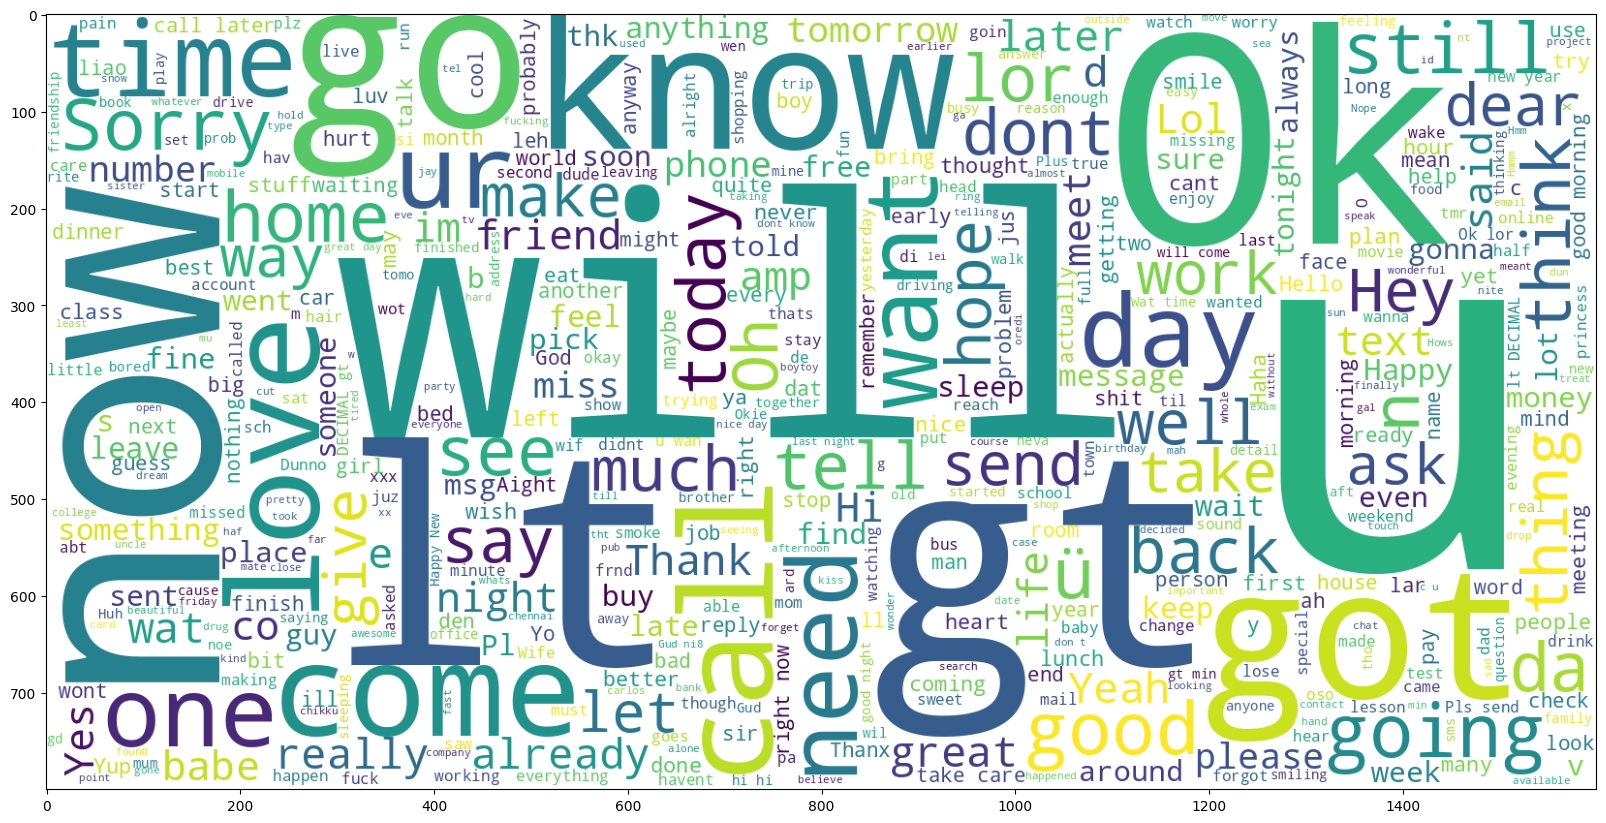

In [17]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 500,background_color='white').generate(" ".join(df[df.label == 1].message))
plt.imshow(wc)

So sánh giữa ham và spam

In [18]:
#create spam corpus which will holds all Spam words
spam_corpus = []
for msg in df[df['label'] == 1]['message'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

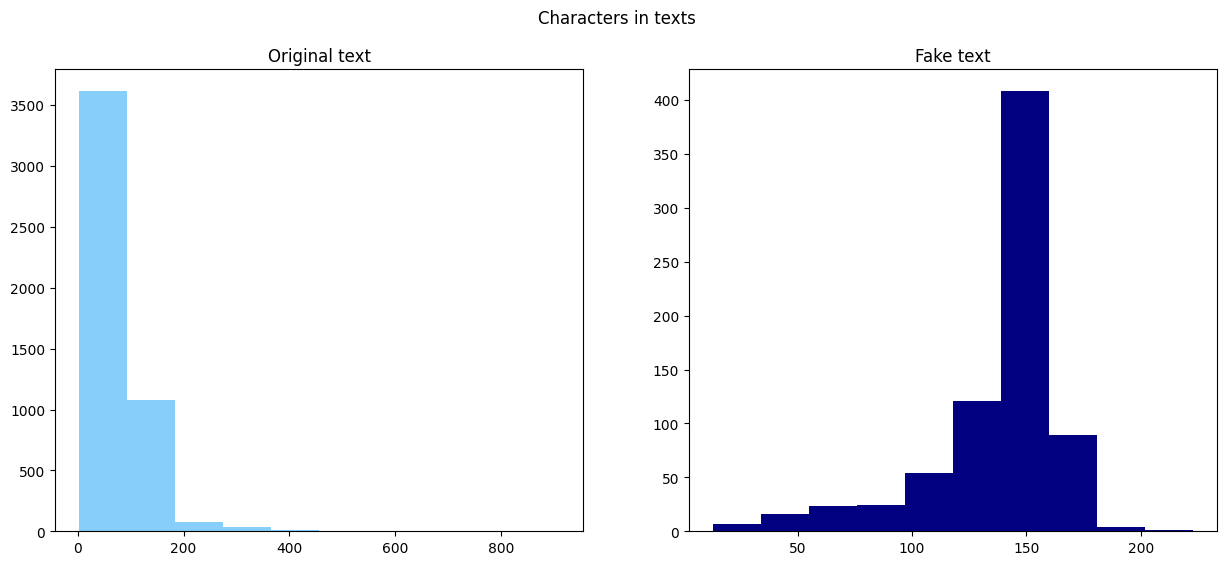

In [19]:
#Characters Visualize
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
text_len=df[df['label']==1]['message'].str.len()
ax1.hist(text_len,color='lightskyblue')
ax1.set_title('Original text')
text_len=df[df['label']==0]['message'].str.len()
ax2.hist(text_len,color='navy')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

In [20]:
df['num_words_transform']=df['message'].apply(lambda x: len(str(x).split()))
df

,label,message,num_char,num_words,num_sen,transformed_text,num_words_transform
0,1,"Go until jurong point, crazy.. Available only ...",111,20,2,go jurong point crazi avail bugi n great world...,20
1,1,Ok lar... Joking wif u oni...,29,6,2,ok lar joke wif u oni,6
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2,free entri 2 wkli comp win fa cup final tkt 21...,28
3,1,U dun say so early hor... U c already then say...,49,11,1,u dun say earli hor u c alreadi say,11
4,1,"Nah I don't think he goes to usf, he lives aro...",61,13,1,nah think goe usf live around though,13
...,...,...,...,...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,160,30,4,2nd time tri 2 contact u pound prize 2 claim e...,30
5568,1,Will ü b going to esplanade fr home?,36,8,1,ü b go esplanad fr home,8
5569,1,"Pity, * was in mood for that. So...any other s...",57,10,2,piti mood suggest,10
5570,1,The guy did some bitching but I acted like i'd...,125,26,1,guy bitch act like interest buy someth els nex...,26


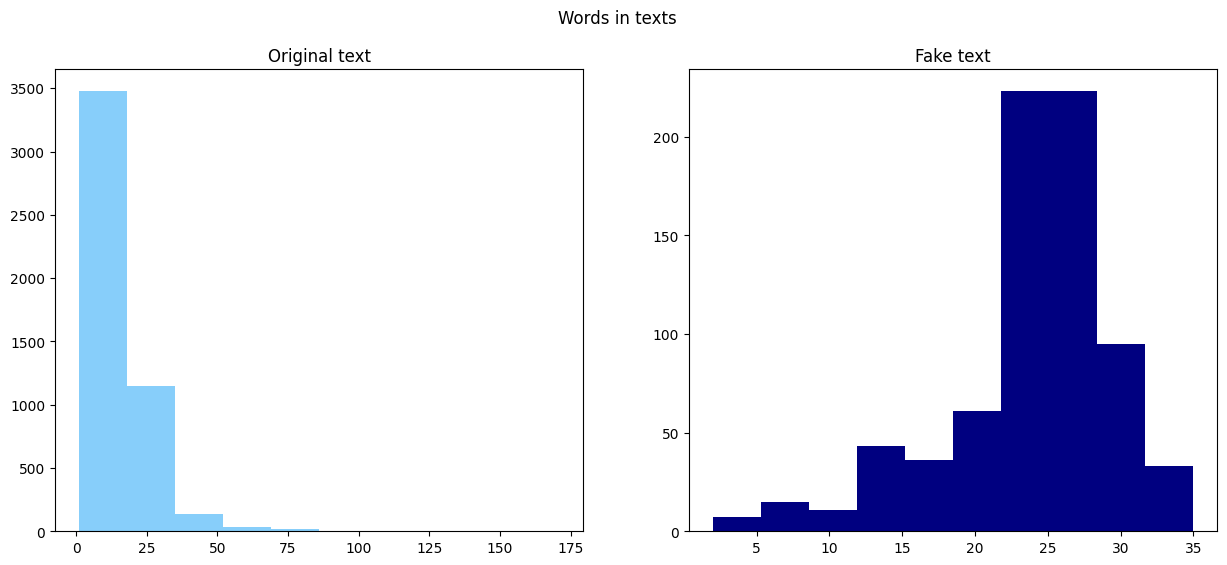

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
text_len=df[df['label']==1]['num_words_transform']
ax1.hist(text_len,color='lightskyblue')
ax1.set_title('Original text')
text_len=df[df['label']==0]['num_words_transform']
ax2.hist(text_len,color='navy')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

# Xây dựng mô hình phân loại sử Naive Bayes

Phương pháp bag of word


In [22]:
!pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['message'])

In [23]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

Xác định input, output

In [24]:
X = tfidf.fit_transform(df['message']).toarray()
y = df['label'].values

Tách tập train và test

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4457, 3000)
y_train shape: (4457,)
X_test shape: (1115, 3000)
y_test shape: (1115,)


Xây dựng mô hình

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB()

# Đánh giá mô hình

In [27]:
y_pred2 = mnb.predict(X_test)
print("Accuracy Score -",accuracy_score(y_test,y_pred2))
print("Precision Score -",precision_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))

Accuracy Score - 0.9695067264573991
Precision Score - 0.9656912209889001
[[124  34]
 [  0 957]]


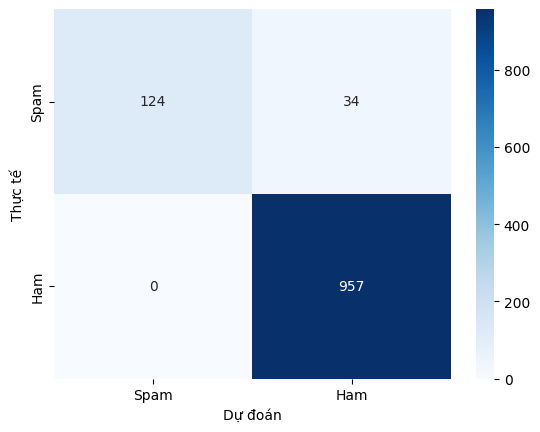

In [29]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_test, y_pred2)

ax = plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='Blues', fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Dự đoán')
ax.set_ylabel('Thực tế')
#ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Spam', 'Ham'])
ax.yaxis.set_ticklabels(['Spam', 'Ham'])
plt.savefig('Spam.PNG')